### Import libraries


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

seed = 7

### Connect to GDrive


In [ ]:
from google.colab import drive

drive.mount('/gdrive')

# write path to the folder with trainig_set_no_outliers.npz
%cd '/gdrive/My Drive/My[2024-2025] AN2DL/HW1'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/My[2024-2025] AN2DL/HW1


### Load Data

In [ ]:
# to create training set without outliers, first look at the DeleteOutliers.ipynb
data = np.load('data/trainig_set_no_outliers.npz')
X = data['images']
y = data['labels']
labels = np.unique(y)
print(f'Unique labels are: {labels}')

Unique labels are: [0 1 2 3 4 5 6 7]


### Look at the distribution of Data


(array([ 848., 2177., 1085., 2020.,  849.,  991., 2330., 1643.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

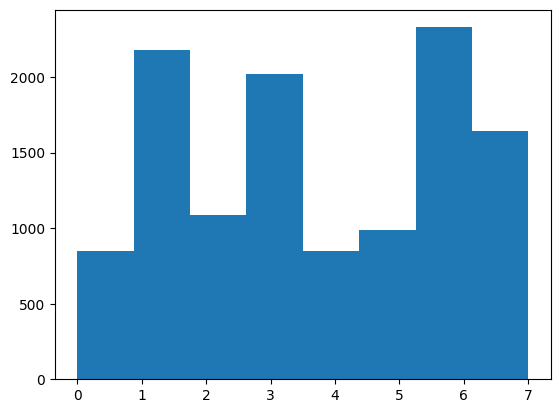

In [ ]:
plt.hist(y, bins = 8)

### Normalize Data

In [ ]:
if X.max()>1:
  X = (X/255).astype("float32")

print(f'Maximum value of X is {X.max()}')

Maximum value of X is 1.0


### Train Val Test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=int(X.shape[0]*0.2),
    random_state=seed,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=int(X_val.shape[0]*0.2),
    random_state=seed,
    stratify=y_val
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [ ]:
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')

X_train shape is (9555, 96, 96, 3)
X_val shape is (1911, 96, 96, 3)
X_test shape is (477, 96, 96, 3)


### Add augmentation

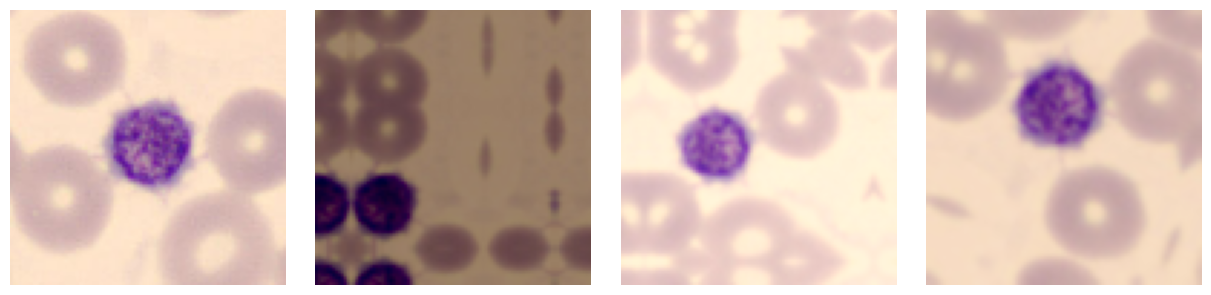

In [ ]:
# Define a sequential model for image augmentation with random flipping
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.4,0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomZoom(0.4),
    tfkl.RandomBrightness(0.4, value_range=(0,1)),

])

img = X_train[0]

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

### Build the Model

In [ ]:
def build_inception_block(x, filters):
  layer_1 = tfkl.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
  layer_1 = tfkl.Conv2D(filters, (3,3), padding='same', activation='relu')(layer_1)

  layer_2 = tfkl.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
  layer_2 = tfkl.Conv2D(filters, (5,5), padding='same', activation='relu')(layer_2)

  layer_3 = tfkl.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
  layer_3 = tfkl.Conv2D(filters, (1,1), padding='same', activation='relu')(layer_3)

  mid_1 = tfkl.concatenate([layer_1, layer_2, layer_3], axis = 3)
  return mid_1

In [ ]:
def build_conv_block(x, filters, order_number, kernel_size=3, padding='same',
                downsample=True, activation='relu', name='conv'):
    # Main convolutional path
    x = tfkl.Conv2D(filters, kernel_size, padding=padding,
                    use_bias=False, name=f'{name}_conv_{order_number}')(x)
    #x = tfkl.BatchNormalization(name=f'{name}_bn_{order_number}')(x)
    x = tfkl.Activation(activation, name=f'{name}_act_{order_number}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool_{order_number}')(x)

    return x

In [ ]:
def build_model(
    input_shape,
    output_shape,
    learning_rate,
    augmentation=None,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Resizing(32,32)(inputs)

    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)
    else:
        x = augmentation(x)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    x = build_inception_block(x, 16)
    x = build_conv_block(x, 32, 1)
    x = build_inception_block(x, 32)
    x = build_conv_block(x, 32, 2)
    x = build_inception_block(x, 32)
    x = build_conv_block(x, 64, 3)
    x = build_conv_block(x, 32, 4)

    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.3)(x)
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

### Define the model

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 64
Learning Rare: 0.001


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ resizing (Resizing)    │ (None, 32, 32, 3)    │            0 │ Input[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ sequential_1           │ (None, 32, 32, 3)    │            0 │ resizing[0][0]      │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_flip_1     │ (None, 32, 32, 3)    │            0 │ -                   │    -    │
│ (RandomFlip)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 32, 3)    │            0 │ -                   │    -    │
│ random_translation_1   │                      │              │                     │         │
│ (RandomTranslation)    │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_rotation_1 │ (None, 32, 32, 3)    │            0 │ -                   │    -    │
│ (RandomRotation)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_zoom_1     │ (None, 32, 32, 3)    │            0 │ -                   │    -    │
│ (RandomZoom)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 32, 3)    │            0 │ -                   │    -    │
│ random_brightness_1    │                      │              │                     │         │
│ (RandomBrightness)     │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv0 (Conv2D)         │ (None, 32, 32, 16)   │          448 │ sequential_1[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 32, 32, 16)   │          272 │ conv0[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 32, 16)   │          272 │ conv0[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 32, 16)   │            0 │ conv0[0][0]         │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 32, 32, 16)   │        2,320 │ conv2d[0][0]        │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 32, 16)   │        6,416 │ conv2d_2[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 32, 32, 16)   │          272 │ max_pooling2d[0][0] │    Y    │
├──────────────────────

 Total params: 201,560 (787.34 KB)

 Trainable params: 201,560 (787.34 KB)

 Non-trainable params: 0 (0.00 B)

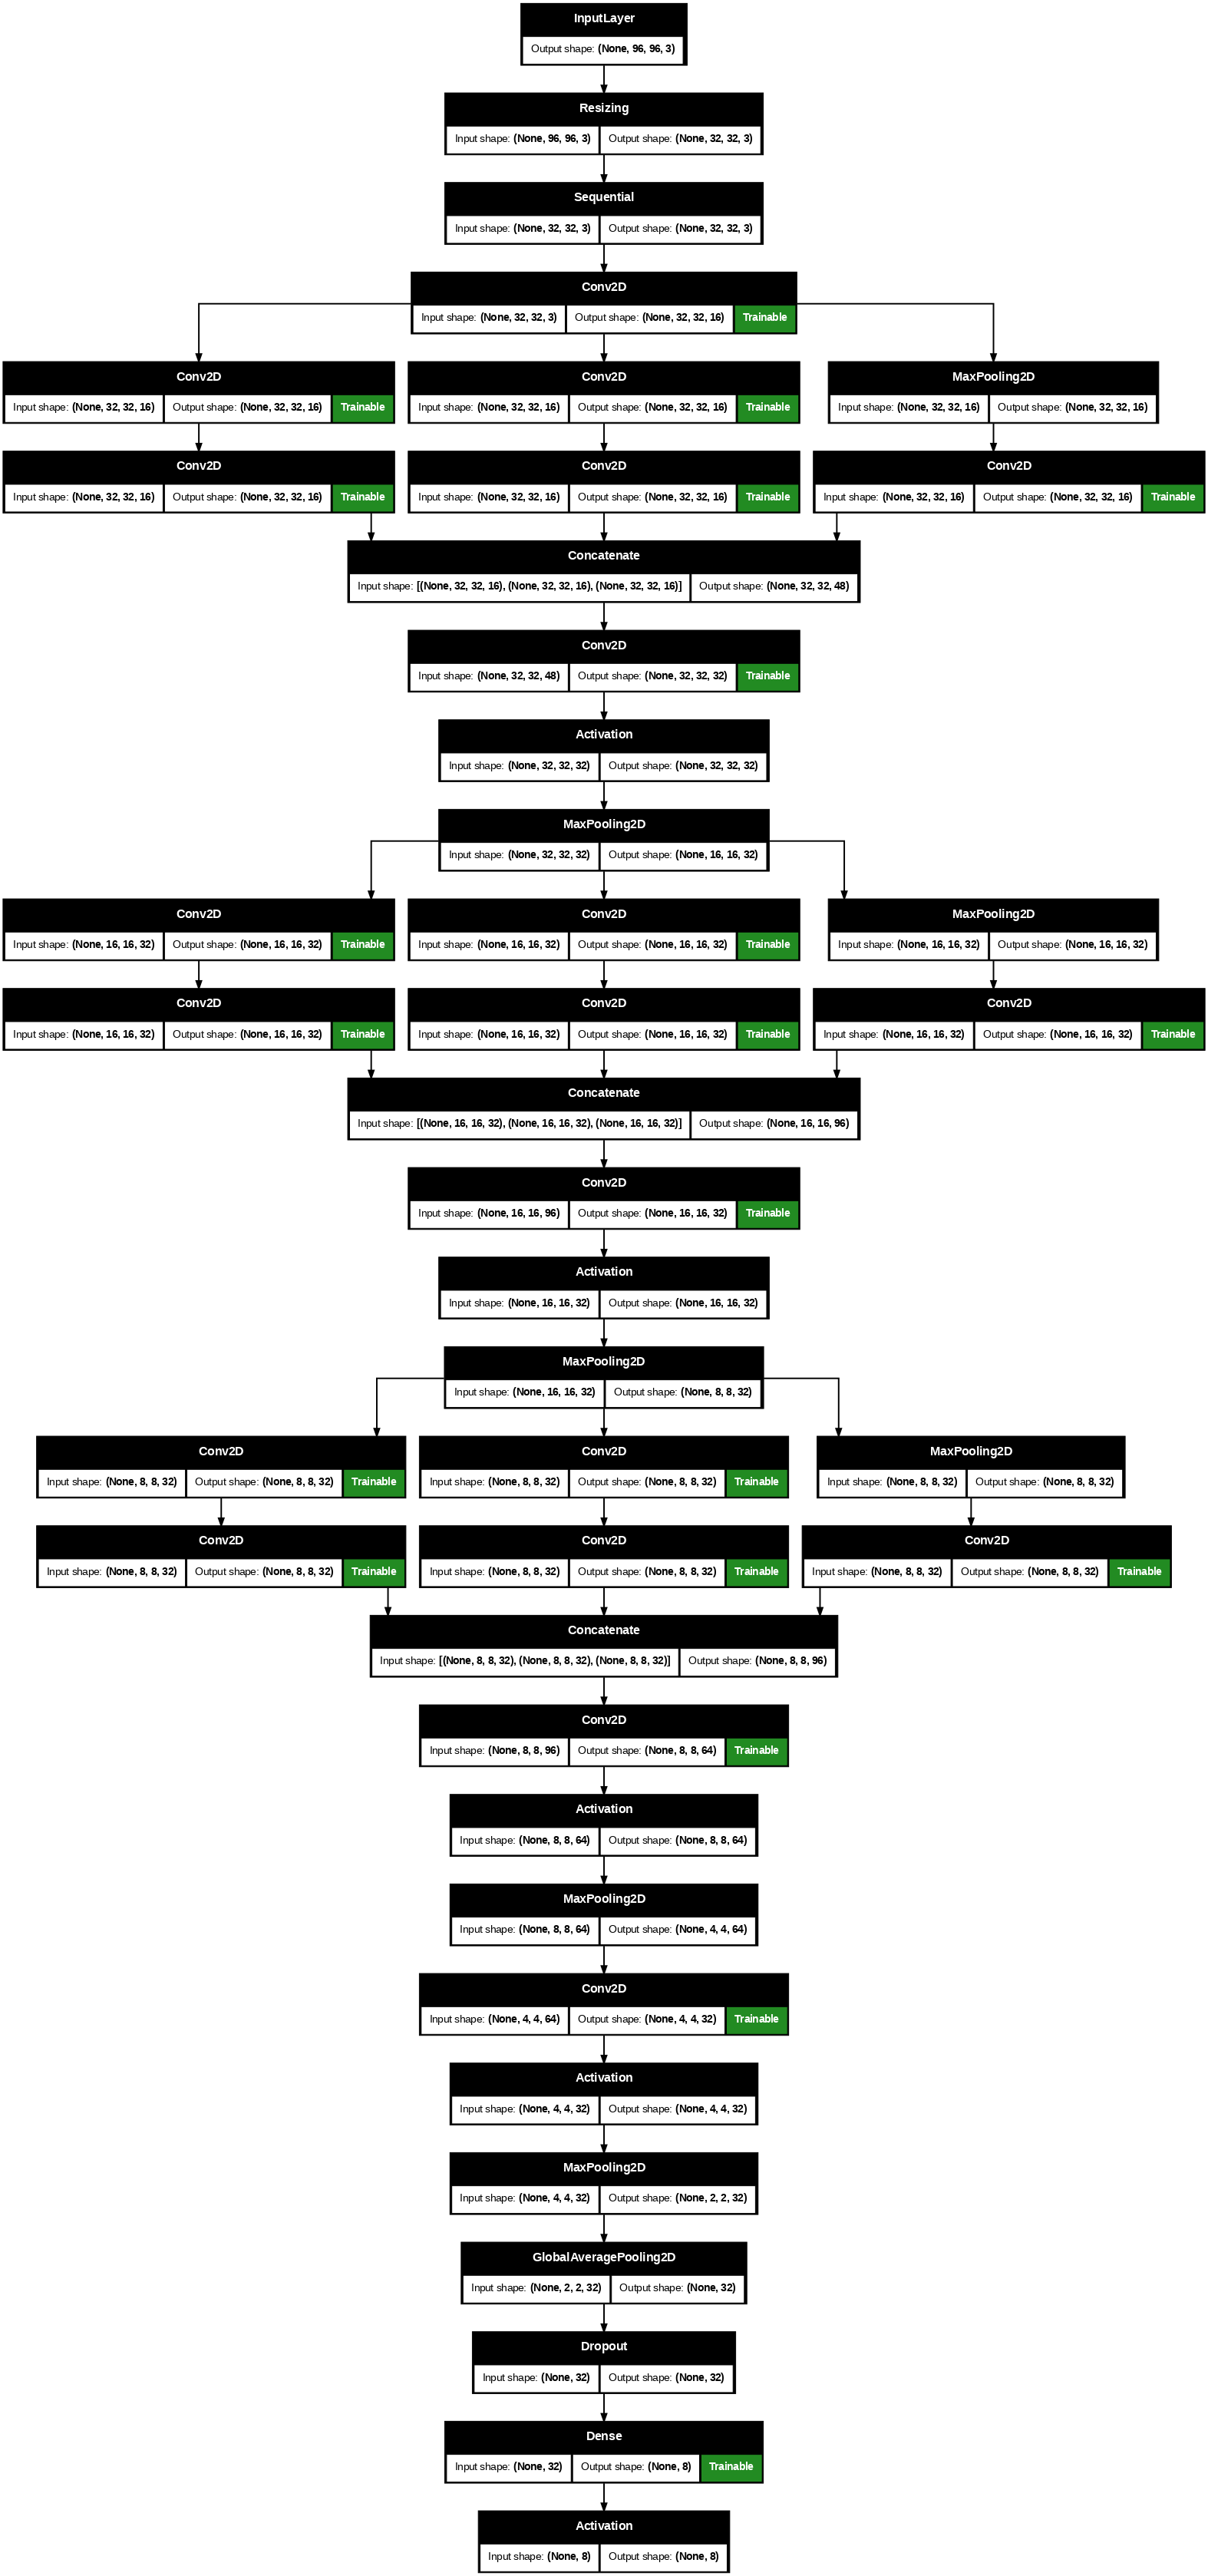

In [ ]:
# Build the model with specified input and output shapes
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.4,0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomZoom(0.4),
    tfkl.RandomBrightness(0.4, value_range=(0,1)),

])

model = build_model(input_shape,
    output_shape,
    learning_rate,
    augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Train the model


In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Inception_custom_CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.1869 - loss: 2.0219 - val_accuracy: 0.4385 - val_loss: 1.6989
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4089 - loss: 1.6039 - val_accuracy: 0.6426 - val_loss: 0.9323
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5666 - loss: 1.1730 - val_accuracy: 0.7514 - val_loss: 0.6832
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6255 - loss: 1.0121 - val_accuracy: 0.7352 - val_loss: 0.6652
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6675 - loss: 0.9042 - val_accuracy: 0.7373 - val_loss: 0.6798
Epoch 6/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7038 - loss: 0.8226 - val_accuracy: 0.7305 - val_loss: 0.6967
Epoch 7/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7067 - loss: 0.8162 - val_accuracy: 0.6714 - val_loss: 1.0393
Epoch 8/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6963 - loss: 

### Plot the training history

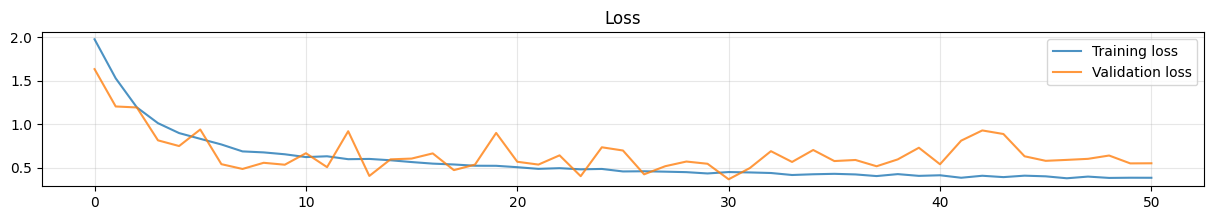

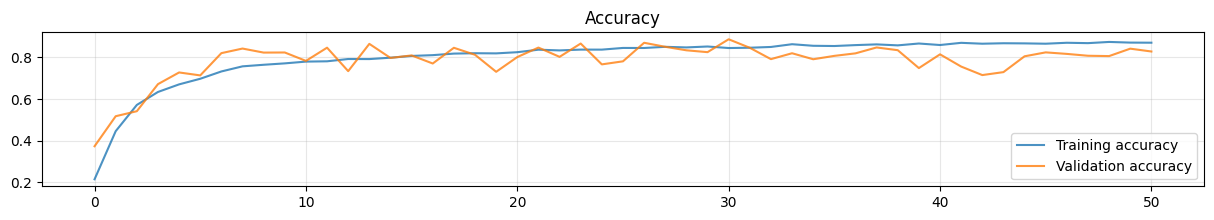

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Make inference

In [ ]:
model = tfk.models.load_model('Inception_custom_CNN_83.78.keras')

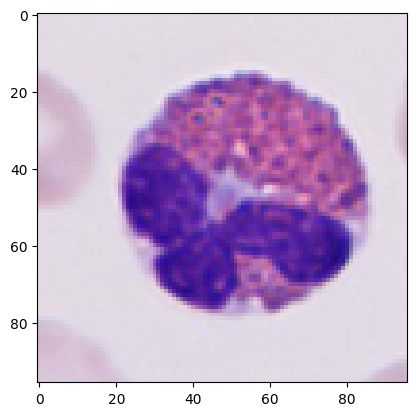

In [ ]:
plt.imshow(X_test[0])

In [ ]:
print(y_test.shape, y_val.shape)

(477, 1) (1911, 8)


In [ ]:
if np.max(X_test)>1:
  X_test = (X_test/255).astype("float32")

predictions = model.predict(X_test, verbose=0)
pred_classes = np.argmax(predictions, axis=-1)
if y_test.shape[1]!=1:
  gt = np.argmax(y_test, axis=1)
else:
  gt = y_test[:, 0]
accuracy = sum(gt == pred_classes) / len(gt)
accuracy

0.9035639412997903